In [1]:
%config InlineBackend.figure_format = 'retina'
#import jax.tools.colab_tpu
#jax.tools.colab_tpu.setup_tpu()
from functools import partial

import time
import numpy as onp
import matplotlib.pyplot as plt 

from einops import rearrange, reduce, repeat

import jax.numpy as np
from jax.lax import scan
from jax import grad, jit, vmap
from jax import random
from jax.ops import index, index_add, index_update
from jax.scipy.signal import correlate

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [2]:
class LSNN():
    def __init__(self, n_inp, n_rec, n_out, tau_rec, tau_out, thr,
                 gamma, lr_inp, lr_rec, lr_out, n_t, reg, f0, dt):
      
        self.n_inp  = n_inp
        self.n_rec  = n_rec
        self.n_out  = n_out
        self.thr    = thr
        self.gamma  = gamma
        self.lr_inp = lr_inp
        self.lr_rec = lr_rec
        self.lr_out = lr_out
        self.n_t    = n_t
        self.reg    = reg
        self.f0     = f0
        self.dt     = dt
        self.alpha  = np.exp(-dt/tau_rec)
        self.kappa  = np.exp(-dt/tau_out)
       
        # Pre-comp
        self.alpha_conv = np.array([self.alpha ** (self.n_t - i - 1) for i in range(self.n_t)]).astype(float) # 1, 1, n_t
        self.kappa_conv = np.array([self.kappa ** (self.n_t - i - 1) for i in range(self.n_t)]).astype(float) # 1, 1, n_t

    @partial(jit, static_argnums=(0,))
    def calc_inp_trace(self, x, h):
        ''' Optimal implementation of e-trace per inp
            correlate in JAX/scipy is conv1d in PyTorch/TF.
            See https://discuss.pytorch.org/t/numpy-convolve-and-conv1d-in-pytorch/12172/4
        '''
        trace_in = repeat(vmap(correlate, in_axes=(0, None))(x, self.alpha_conv)[:,0:self.n_t], 'i t -> r i t', r=self.n_rec) # in, t
        trace_in = np.einsum('tr,rit->rit', h, trace_in)  # n_r, inp_dim, n_t
        trace_in = vmap(correlate, in_axes=(0, None))(trace_in.reshape(self.n_inp*self.n_rec, self.n_t), self.kappa_conv)[:,0:self.n_t].reshape(self.n_rec, self.n_inp, self.n_t)
        return trace_in

    @partial(jit, static_argnums=(0,))
    def calc_rec_trace(self, z, h):
        trace_rec = repeat(vmap(correlate, in_axes=(0, None))(z.T, self.alpha_conv)[:,0:self.n_t], 'i t -> r i t', r=self.n_rec) # in, t
        trace_rec = np.einsum('tr,rit->rit', h, trace_rec) # n_r, inp_dim, n_t
        trace_rec = vmap(correlate, in_axes=(0, None))(trace_rec.reshape(self.n_rec*self.n_rec, self.n_t), self.kappa_conv)[:,0:self.n_t].reshape(self.n_rec, self.n_rec, self.n_t)
        return trace_rec

    @partial(jit, static_argnums=(0,))
    def calc_out_trace(self, z):
        trace_out = vmap(correlate, in_axes=(0, None))(z.T, self.kappa_conv)[:,0:self.n_t]
        return trace_out

    @partial(jit, static_argnums=(0,))
    def calc_fr(self, z):
        fr = np.sum(z, axis=(0)) / (self.n_t * self.dt) 
        reg_term = fr - self.f0
        return reg_term
    
    @partial(jit, static_argnums=(0,))
    def pseudo_der(self, v):
        return self.gamma * np.maximum(np.zeros_like(v), 1 - np.abs((v-self.thr)/self.thr))
    
    @partial(jit, static_argnums=(0,))
    def forward(self, theta, x):

        # Reset diagonal
        rec_weight = (- theta['rec'] * (np.eye(self.n_rec) - 1)).T
        inp_weight = theta['inp'].T
        out_weight = theta['out'].T
        
        def f(carry, x):
            v_curr   = carry[0]
            z_curr   = carry[1]
            vo_curr  = carry[2]
            not_init = carry[3]

            v_next  = (self.alpha * v_curr + np.matmul(z_curr, rec_weight) + np.matmul(x, inp_weight) - z_curr * self.thr) * not_init
            z_next  = (v_next > self.thr).astype(np.float32) * not_init
            vo_next = (self.kappa * vo_curr + np.matmul(z_next, out_weight) ) * not_init

            carry = [v_next, z_next, vo_next,  True]
            y = [v_next, z_next, vo_next]
            return carry, y

        _, (v,z,vo) = scan(f, [np.zeros((self.n_rec)), np.zeros((self.n_rec)), np.zeros((self.n_out)), False], x.T)

        # Pseudo-derivative
        h = self.pseudo_der(v) # nt, nb, nrec

        # E-trace calculation
        traces = {}
        traces['inp'] = self.calc_inp_trace(x, h)
        traces['rec'] = self.calc_rec_trace(z, h)
        traces['out'] = self.calc_out_trace(z)
        
        # Calc firing rate
        reg_term = self.calc_fr(z)
        return vo, traces, reg_term
    
    @partial(jit, static_argnums=(0,))
    def acc_gradient(self, err, traces, reg_term, theta):
        L_loss = np.einsum('t o, o r -> r t', err, theta['fb'])
        L_reg  = repeat(reg_term, 'r -> r (t) ', t=self.n_t)

        L = L_loss + self.reg * L_reg

        grads = {}
        grads['inp']  =   np.clip(-100, np.sum(np.einsum('xt,xyt->xyt', L, traces['inp']), axis=2), 100)
        grads['rec']  =   np.clip(-100, np.sum(np.einsum('xt,xyt->xyt', L, traces['rec']), axis=2), 100)
        grads['out']  =   np.clip(-100, np.einsum('to,rt->or', err, traces['out']), 100)
        return grads
    
    @partial(jit, static_argnums=(0,))
    def upd_weights(self, theta, grads):
        theta['inp'] = np.clip(-1, theta['inp'] - self.lr_inp * grads['inp'], 1)
        theta['rec'] = np.clip(-1, theta['rec'] - self.lr_rec * grads['rec'], 1)
        theta['out'] = np.clip(-1, theta['out'] - self.lr_out * grads['out'], 1)
        return theta

In [3]:
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

class Sinusoids(Dataset):
    def __init__(self, seq_length=1000, num_samples=2, num_inputs=80, input_freq=50):
        self.seq_length   = seq_length
        self.num_inputs   = num_inputs
        self.num_samples  = num_samples
        self.freq_list    = torch.tensor([1, 2, 3, 5]) # Hz
        self.dt           = 1e-3 # s
        self.t            = torch.arange(0, 1, self.dt) # s
        self.inp_freq     = input_freq

        # Random input
        self.x = (torch.rand(self.num_samples, self.num_inputs, self.seq_length) < self.dt * self.inp_freq).float()

        # Randomized output amplitude and phase
        amplitude_list = torch.FloatTensor(self.num_samples, len(self.freq_list)).uniform_(0.5, 2)
        phase_list = torch.FloatTensor(self.num_samples, len(self.freq_list)).uniform_(0, 2 * math.pi)

        # Normalized sum of sinusoids
        self.y = torch.zeros(self.num_samples, self.seq_length)
        for i in range(self.num_samples):
          summed_sinusoid = sum([amplitude_list[i, ix] * torch.sin(2*math.pi*f*self.t + phase_list[i, ix]) for ix, f in enumerate(self.freq_list)])
          self.y[i, :] = summed_sinusoid/torch.max(torch.abs(summed_sinusoid))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.x[idx], self.y[idx]



sinusoid_dataset = Sinusoids(seq_length=1000, num_samples=5, num_inputs=100, input_freq=50)

# Parameters
train_percentage = 50
batch_size = 1

train_size = int(len(sinusoid_dataset) * train_percentage/100)
train_set, _ = random_split(sinusoid_dataset, [train_size, len(sinusoid_dataset)-train_size])

train_data = DataLoader(train_set, batch_size, shuffle=True)

In [4]:
def initialize_parameters(key, n_inp, n_rec, n_out, w_gain):
    theta = {}
    theta['inp'] = random.normal(key, (n_rec, n_inp)) * w_gain
    theta['rec'] = random.normal(key, (n_rec, n_rec)) * w_gain
    theta['out'] = random.normal(key, (n_out, n_rec)) * w_gain
    theta['fb']  = random.normal(key, (n_out, n_rec)) * w_gain
    return theta

@jit
def mse_loss(x,y):
    return np.mean(np.power(x-y, 2))

In [20]:
####
# Parameters
####
epochs = 100
n_inp = 100
n_rec = 100
n_out = 1
tau_rec = 30e-3
tau_out = 30e-3
thr = 0.1
gamma = 0.3
lr_inp = 2e-4
lr_rec = 6e-4
lr_out = 2e-4
n_t = 1000
reg =1e-4
f0 = 4
w_gain = 0.01
dt = 1e-3

theta = initialize_parameters(key, n_inp, n_rec, n_out, w_gain)

lsnn =  LSNN(n_inp, n_rec, n_out, tau_rec, tau_out, thr,
             gamma, lr_inp, lr_rec, lr_out, n_t, reg, f0, dt)

loss_arr = []
fr_arr   = []
for epoch in range(epochs):
    for _, (x, y) in enumerate(train_data):
        y = y.permute(1,0)
        x = np.array(onp.array(x.squeeze(0)))        
        y = np.array(onp.array(y))
        
        yhat, traces, reg_term = lsnn.forward(theta, x)
        loss   = yhat-y # Going with the derivative of (yhat-y)^2
        grads  = lsnn.acc_gradient(loss, traces, reg_term, theta)
        theta  = lsnn.upd_weights(theta, grads)
        loss_arr.append(mse_loss(yhat,y))
        
    if epoch%10 == 0:
        print(f'Epoch: [{epoch}/{epochs}] - MSE Loss: {mse_loss(yhat, y):.4f}')

Epoch: [0/100] - MSE Loss: 0.3701
Epoch: [10/100] - MSE Loss: 0.1434
Epoch: [20/100] - MSE Loss: 0.1239
Epoch: [30/100] - MSE Loss: 0.0664
Epoch: [40/100] - MSE Loss: 0.0337
Epoch: [50/100] - MSE Loss: 0.0277
Epoch: [60/100] - MSE Loss: 0.0249
Epoch: [70/100] - MSE Loss: 0.0269
Epoch: [80/100] - MSE Loss: 0.0217
Epoch: [90/100] - MSE Loss: 0.0205


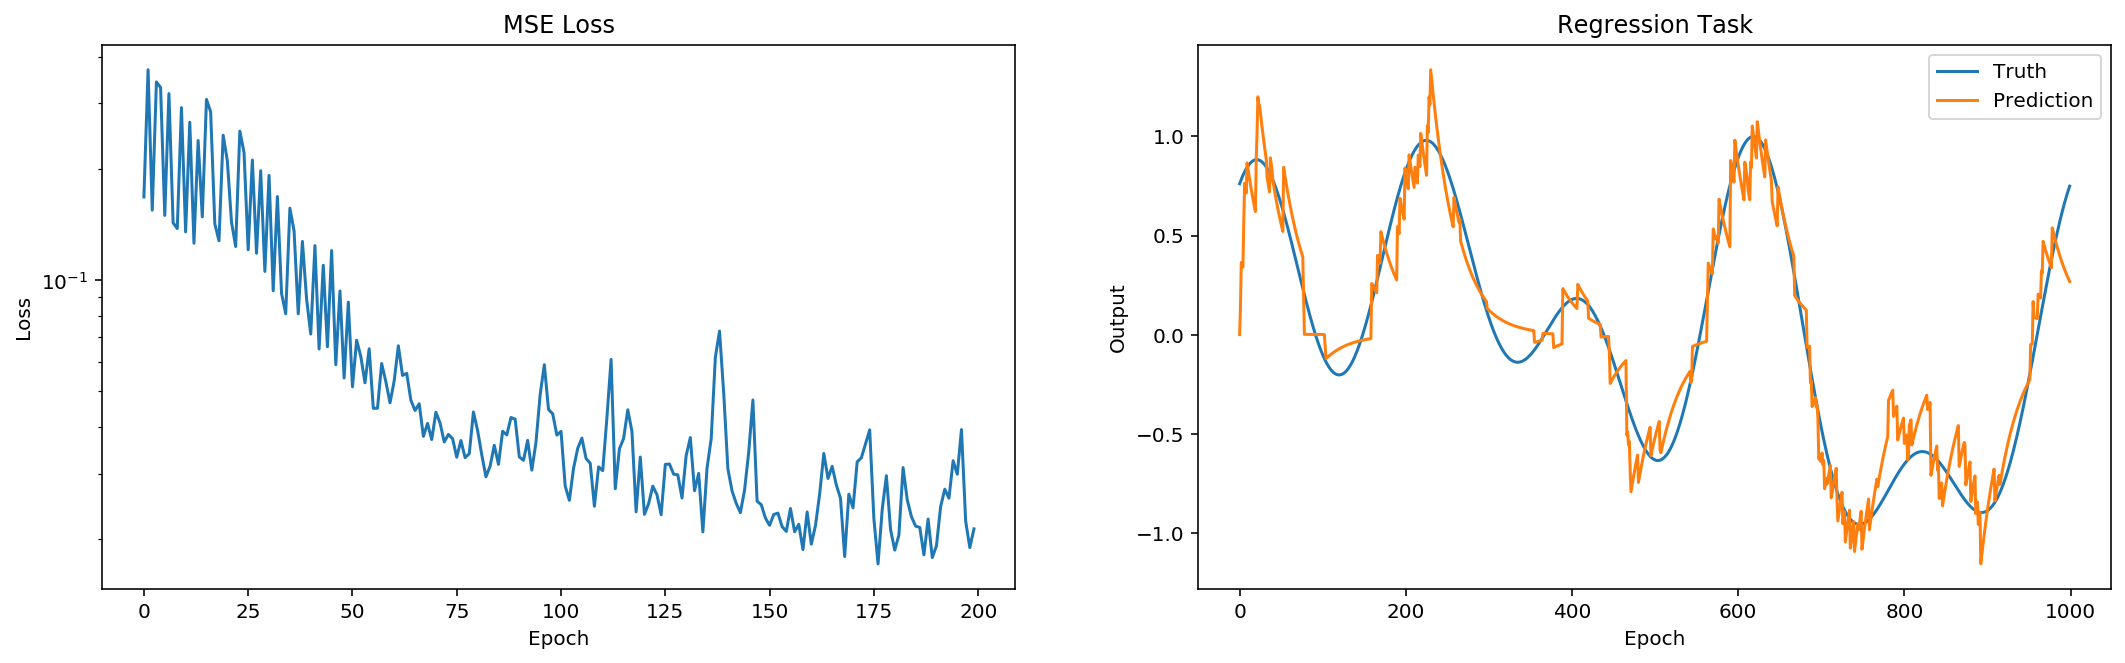

In [21]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.semilogy(loss_arr)
plt.subplot(122)
plt.title('Regression Task')
plt.xlabel('Epoch')
plt.ylabel('Output')
plt.plot(y, label='Truth')
plt.plot(yhat, label='Prediction')
plt.legend()